# Bernstein-Vazirani Algorithm

In [1]:
%pip install uv 
!uv pip install 'iqm-client[qiskit]==29.14' 
%pip install lagrangeclient --index-url https://gitlab.linksfoundation.com/api/v4/projects/1709/packages/pypi/simple

%pip install qiskit-aer==0.16.1

%pip install galois

%pip install matplotlib pylatexenc

from IPython.display import clear_output
clear_output()

First let us take care of the required imports. 

In [2]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import numpy as np
import galois

from iqm.qiskit_iqm import IQMProvider
from qiskit import transpile

/Users/ema/miniconda3/envs/corso_qc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


To implement the Deutsch-Jozsa algorithm in Qiskit, we'll start by defining a function that implements a query gate for the Bernstein-Vazirani problem given any binary string *s*. 


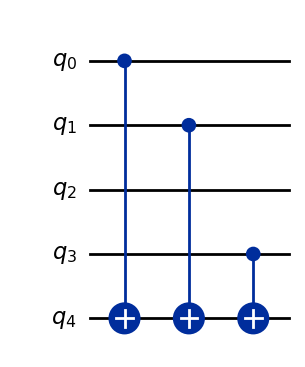

In [3]:
def bv_query(s):
    # Create a quantum circuit implementing a query gate for the
    # Bernstein-Vazirani problem.

    qc = QuantumCircuit(len(s) + 1)
    for index, bit in enumerate(reversed(s)):
        if bit == "1":
            qc.cx(index, len(s))
    return qc

display(bv_query("1011").draw(output="mpl"))

Next we define a function that creates the Deutsch-Jozsa circuit, taking a quantum circuit implementation of a query gate as an argument.

In [4]:
def compile_circuit(function: QuantumCircuit):
    # Compiles a circuit for use in the Deutsch-Jozsa algorithm.

    n = function.num_qubits - 1
    qc = QuantumCircuit(n + 1, n)
    qc.x(n)
    qc.h(range(n + 1))
    qc.compose(function, inplace=True)
    qc.h(range(n))
    qc.measure(range(n), range(n))
    return qc

Now we can create a function that runs the Deutsch-Jozsa circuit on the function, using the compile_circuit function that was defined previously.

In [6]:
def bv_algorithm(function: QuantumCircuit, backend=AerSimulator()):
    qc = compile_circuit(function)
    transpiled_qc = transpile(qc, backend=backend)

    result = backend.run(transpiled_qc, shots=1024).result()
    print("counts:",result.get_counts())

    return max(result.get_counts(), key=result.get_counts().get)

display("solution: " + bv_algorithm(bv_query("1011")))

counts: {'1011': 1024}


'solution: 1011'

In [ ]:
!lagrangeclient

## On Windows
# import sys
# !{sys.executable} -m lagrangeclient



== DEVICE LOGIN FLOW ==
🔗 Visit this URL in your browser:
https://spark.quantum.linksfoundation.com/auth/realms/cortex/device?user_code=BPGR-RXJB
Waiting for user to complete login...
=========== TOKEN ===========
eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJPN2g5cUtOOGRsdi1OZlo3Qm10NEJNZC0yaUFnMWt5STFEa2h0R3M5OU5rIn0.eyJleHAiOjE3NjI5NDI4ODMsImlhdCI6MTc2MjMzODA4MywiYXV0aF90aW1lIjoxNzYyMzMyODI4LCJqdGkiOiJvbnJ0ZGc6MTk1NDc4ZDQtMzI3NC1iYTNkLTMzNzgtODE0NTA1Y2ZmNjYyIiwiaXNzIjoiaHR0cHM6Ly9zcGFyay5xdWFudHVtLmxpbmtzZm91bmRhdGlvbi5jb20vYXV0aC9yZWFsbXMvY29ydGV4IiwiYXVkIjoiYWNjb3VudCIsInN1YiI6IjRjZmJkMGZmLWEwMzktNGZhYS05NDc2LWVjMjFkNTgzZGQ5NSIsInR5cCI6IkJlYXJlciIsImF6cCI6ImlxbV9jbGllbnQiLCJzaWQiOiIyMmY1MzZiMC0zYzdkLTQ3NTktYmVlZi05NDQwMDdlZDQyYTkiLCJhY3IiOiIwIiwiYWxsb3dlZC1vcmlnaW5zIjpbImh0dHBzOi8vc3BhcmsucXVhbnR1bS5saW5rc2ZvdW5kYXRpb24uY29tLyoiLCJodHRwczovL2lxbXNwYXJrLnBvbGl0by5pdC8iXSwicmVhbG1fYWNjZXNzIjp7InJvbGVzIjpbImV4YV9hZG1pbiIsIm9mZmxpbmVfYWNjZXNzIiwicGxhdGZvcm0tYWRtaW4iLCJjb3J0ZXhfYW

In [7]:
import json
with open('tokens.json', 'r') as f:
    config = json.load(f)
access_token = config['access_token']

In [8]:
provider = IQMProvider(url="https://spark.quantum.linksfoundation.com/station", token=access_token)
lagrange_backend = provider.get_backend()

display("solution: " + bv_algorithm(bv_query("1011"), backend=lagrange_backend))

station-control-client version '9.18.0' is newer minor version than '9.4.0' used by the station control server, some new client features might not be supported.


counts: {'1011': 914, '0011': 38, '1001': 23, '1010': 24, '0010': 4, '1110': 1, '0000': 6, '1111': 8, '0001': 3, '1000': 3}


'solution: 1011'

# Simon's Algorithm

To implement Simon's algorithm in Qiskit, we'll use the fact that we can convert unitary matrices into gates in Qiskit using the .unitary method. Specifically, we'll use this methodology to define a query gate for a randomly chosen function satisfying Simon's problem for a given string *s*.

In [9]:
def simon_function(s: str):
    # Create a QuantumCircuit implementing a query gate for Simon problem obeying the
    # promise for the hidden string `s`

    # The quantum circuit will have 2n qubits for n being the length of s
    n = len(s)
    qc = QuantumCircuit(2 * n)

    # Define a random permutation of all n bit strings. This permutation will
    # effectively hide the string s.
    pi = np.random.permutation(2**n)

    # Now we'll define a query gate explicitly. The idea is to first define a function
    # g(x) = min{x,x ^ s}, which is a very simple function that satisfies the promise.
    # (The operation ^ is the bitwise XOR.) Then we take f to be the composition of g
    # and the random permutation pi. This gives us a random function satisfying the
    # promise for s.

    query_gate = np.zeros((4**n, 4**n))
    for x in range(2**n):
        for y in range(2**n):
            z = y ^ pi[min(x, x ^ int(s, 2))]
            query_gate[x + 2**n * z, x + 2**n * y] = 1

    # Our circuit has just this one query gate
    qc.unitary(query_gate, range(2 * n))
    return qc

Next we'll define a function that runs the circuit in Simon's problem 
*k* times and reports the results.

In [10]:
def simon_measurements(problem: QuantumCircuit, k: int, backend=AerSimulator()):
    # This is the quantum part of Simon's algorithm. Given a `QuantumCircuit` that
    # implements f, gets k measurement outcomes to be post-processed later.

    n = problem.num_qubits // 2

    qc = QuantumCircuit(2 * n, n)
    qc.h(range(n))
    qc.compose(problem, inplace=True)
    qc.h(range(n))
    qc.measure(range(n), range(n))

    transpiled_qc = transpile(qc, backend=backend)

    result = backend.run(transpiled_qc, shots=k).result()
    return result.get_counts().keys()

Running this function on a randomly chosen query gate generates k output strings. The length of the hidden string s can be increased, but keep in mind that the simulation takes time exponential in the length of s — so don't run this code on too long of a string if you don't want to wait!

In [42]:
display(simon_measurements(simon_function("10011"),k=12))

dict_keys(['00000', '10110', '10001', '11001', '10101', '11010', '00011', '01111', '10010', '11110'])

We installed the galois extension because it has a built-in function for computing the null space modulo 2, which allows us to do the required postprocessing.

In [ ]:
def simon_algorithm(problem: QuantumCircuit):
    # Given a `QuantumCircuit` that implements a query gate for Simon problem, return
    # the hidden string `s`.

    # Quantum part: run the circuit defined previously k times and gather the measurement
    # results. Replace +10 by +r for any nonnegative integer r depending on desired
    # confidence.

    measurements = simon_measurements(problem, k=problem.num_qubits // 2 + 10, backend=AerSimulator())

    # Classical post-processing:

    # 1. Convert measurements of form '11101' to 2D-array of integers
    matrix = np.array([list(bitstring) for bitstring in measurements]).astype(int)

    # 2. Interpret matrix as using arithmetic mod 2, and find null space
    null_space = galois.GF(2)(matrix).null_space()

    # 3. Convert back to a string
    print("Guess for hidden string s: ")
    if len(null_space) == 0:
        # No non-trivial solution; `s` is all-zeros
        return "0" * len(list(measurements)[0])
    return "".join(np.array(null_space[0]).astype(str))

And finally we can try it out.

In [28]:
display(simon_algorithm(simon_function("10011")))

Guess for hidden string s: 


'10011'